In [1]:
import numpy as np
from engine import AdvRw2, AdvRwGridworld
from agent import ExpSmoother, FPLearningAgent, Level2QAgent, RandomAgent, IndQLearningAgent
from agent import Level3QAgent, Level3QAgentMixExp, Level3QAgentMixDir, IndQLearningAgentSoftmax, Level2QAgentSoftmax
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot(r0ss, r1ss, dir=None):
    # We set a fancy theme
    plt.style.use('ggplot')
    N_EXP = len(r0ss)
    #plt.axis([0, max_steps*n_iter, -4.5, 1.5])
    for i in range(N_EXP):
        plt.plot(moving_average(r0ss[i], 100), 'b', alpha=0.05)
        #plt.plot(moving_average(r1ss[i], 100), 'r', alpha=0.05)

    plt.plot(moving_average(np.asarray(r0ss).mean(axis=0), 100), 'b', alpha=0.5)
    #plt.plot(moving_average(np.asarray(r1ss).mean(axis=0), 100), 'r', alpha=0.5)

    plt.xlabel('t');
    plt.ylabel('R');

    from matplotlib.lines import Line2D
    cmap = plt.cm.coolwarm
    custom_lines = [Line2D([0], [0], color='b'),
                    Line2D([0], [0], color='r')]

    #plt.legend(custom_lines,['Agent A']);
    if dir is not None:
        plt.savefig(dir + '.png')

0
1
2
3
4


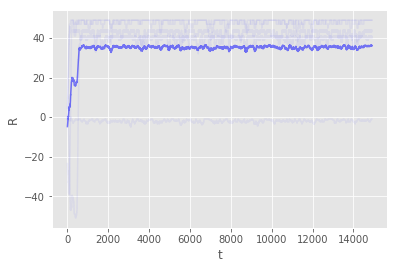

In [22]:
N_EXP = 5

r0ss = []
r1ss = []
#
for n in range(N_EXP):

    gamma = 0.8

    env = AdvRwGridworld(max_steps=10, batch_size=1)
    n_states = 12
    ##
    P2 = ExpSmoother(env.available_actions_Adv, env.available_actions_Adv, learning_rate=0.7)
    #P1 =  RandomAgent( env.available_actions, p=0.5)
    P1 = IndQLearningAgent(env.available_actions_DM, n_states, learning_rate=0.5,
                           epsilon=0.1, gamma=gamma, enemy_action_space=None)
    P1 = Level2QAgentSoftmax(env.available_actions_DM, env.available_actions_Adv, n_states=12,
                       learning_rate=.5, epsilon=0.01, gamma=gamma)

    
    n_iter = 15000        


    r0s = []
    r1s = []
    

    for i in range(n_iter):

        # A full episode:
        done = False
        env.reset()
        s = 7

        while not done:
            
            
            episode_rewards_DM = 0

            # Agents decide
            a1 = P1.act(s)
            a2 = P2.act()
            # This is to test the neutral adversary
            #a2 = np.random.choice(2, p=[0.9, 0.1])


            # World changes
            s_new, rewards, done =  env.step([a1,a2])


            # Agents learn

            P1.update(s, [a1, a2], [rewards[0], rewards[1]], s_new)
            #P1.epsilon *= 0.99
            if s_new == 0 or s_new == 8:  # the adversary only updates after choice
                if s_new == 0:
                    P2.update(0, [a2, 0], [rewards[1], rewards[0]], 0)
                else:
                    P2.update(0, [a2, 1], [rewards[1], rewards[0]], 0)

            s = s_new  
            #print(r0, r1)
            episode_rewards_DM += rewards[0]
            r1s.append(rewards[1])

        r0s.append(episode_rewards_DM)
        env.reset()
        if i%10 == 0:
            P1.epsilonA *= 0.995
            P1.epsilonB *= 0.9
        
    print(n)
    r0ss.append(r0s)
    r1ss.append(r0s)
    
plot(r0ss, r1ss)

In [32]:
def do_robustness_exp(learning_rate, learning_rate_adv, init_epsilon):

    N_EXP = 5

    r0ss = []
    r1ss = []
    #
    for n in range(N_EXP):

        gamma = 0.8

        env = AdvRwGridworld(max_steps=100, batch_size=1)
        n_states = 12
        ##

        P2 = ExpSmoother(env.available_actions_Adv, env.available_actions_Adv, learning_rate=0.75)
        #P2 = Level2QAgent(env.available_actions_Adv,env.available_actions_Adv, n_states=12,
        #                   learning_rate=0.1, epsilon=0.1, gamma=gamma)
        #P1 =  RandomAgent( env.available_actions, p=0.5)
        P1 = Level2QAgent(env.available_actions_DM, env.available_actions_Adv, n_states=12,
                           learning_rate=learning_rate, epsilon=init_epsilon, gamma=gamma)

        P1.enemy.alpha = learning_rate_adv


        n_iter = 15000        


        r0s = []
        r1s = []


        for i in range(n_iter):

            # A full episode:
            done = False
            env.reset()
            s = 7

            while not done:


                episode_rewards_DM = 0

                # Agents decide
                a1 = P1.act(s)
                a2 = P2.act(s)
                # This is to test the neutral adversary
                #a2 = np.random.choice(2, p=[0.9, 0.1])


                # World changes
                s_new, rewards, done = env.step([a1,a2])


                # Agents learn
                if s_new == 0 or s_new == 8:  # the adversary only updates after choice

                    P1.update(s, [a1, a2], [rewards[0], rewards[1]], s_new)


                    if s_new == 0:
                        P2.update(0, [a2, 0], [rewards[1], rewards[0]], 0)
                    else:
                        P2.update(0, [a2, 1], [rewards[1], rewards[0]], 0)


                s = s_new  
                #print(r0, r1)
                episode_rewards_DM += rewards[0]
                r1s.append(rewards[1])

            r0s.append(episode_rewards_DM)
            env.reset()

            if i%10 == 0:
                P1.epsilonA *= 0.995
                P1.epsilonB *= 0.9

            #print(P1.epsilonA)


        print(n)
        #print(P1.prob_type/P1.prob_type.sum())
        r0ss.append(r0s[-3000:])
        r1ss.append(r0s)
    
    return np.mean(r0ss), np.std(r0ss)

In [34]:
lrs = np.asarray([0.01, 0.1, 0.5])
lrs_enemy = np.asarray([0.5, 2])
init_eps = np.asarray([0.5, 0.1, 0.01])

rewards = np.zeros([3, 2, 3])
stds = np.zeros([3, 2, 3])

for i, lr in enumerate(lrs):
    for j, lr_enemy in enumerate(lrs_enemy):
        for k, init_ep in enumerate(init_eps):
            rewards[i,j,k], stds[i,j,k] = do_robustness_exp(lr, lr*lr_enemy, init_ep)
            print(lr, lr_enemy, init_ep, rewards[i,j,k], stds[i,j,k])

0
1
2
3
4
0.01 0.5 0.5 15.46 47.21301091860167
0
1
2
3
4
0.01 0.5 0.1 40.77333333333333 27.477056287423196
0
1
2
3
4
0.01 0.5 0.01 46.32 16.149848296501112
0
1
2
3
4
0.01 2.0 0.5 15.58 47.171003805303954
0
1
2
3
4
0.01 2.0 0.1 43.053333333333335 23.64960511768055
0
1
2
3
4
0.01 2.0 0.01 47.81333333333333 10.828595887227893
0
1
2
3
4
0.1 0.5 0.5 15.3 47.268488446321186
0
1
2
3
4
0.1 0.5 0.1 42.82 24.07919433868168
0
1
2
3
4
0.1 0.5 0.01 48.34 8.097184695929817
0
1
2
3
4
0.1 2.0 0.5 15.966666666666667 47.03330970942
0
1
2
3
4
0.1 2.0 0.1 43.04666666666667 23.662019262006265
0
1
2
3
4
0.1 2.0 0.01 48.513333333333335 6.9591538438392195
0
1
2
3
4
0.5 0.5 0.5 15.946666666666667 47.0405196494351
0
1
2
3
4
0.5 0.5 0.1 43.06 23.6371825732256
0
1
2
3
4
0.5 0.5 0.01 48.406666666666666 7.679927661696357
0
1
2
3
4
0.5 2.0 0.5 15.193333333333333 47.30513667198897
0
1
2
3
4
0.5 2.0 0.1 42.98 23.7857015872982
0
1
2
3
4
0.5 2.0 0.01 48.53333333333333 6.8153421696118
